[Outline](https://docs.google.com/document/d/1ZYcoJ55JDDaQR8YjjVNf6TP8i7yIxWKVmozY3buzZHI/edit)

In [94]:
from collections import Counter
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.rcParams['font.size'] = 12

In [2]:
with open('results/cache/result_run_9268772.json', 'r') as f:
    pred = json.load(f)
pred[0]

[{'answer': 'down', 'question_id': 262148000},
 {'answer': 'watching', 'question_id': 262148001},
 {'answer': 'picnic table', 'question_id': 262148002},
 {'answer': 'flickr', 'question_id': 393225000},
 {'answer': 'no', 'question_id': 393225001}]

In [3]:
with open('data/vqa/raw/v2_OpenEnded_mscoco_val2014_questions.json') as f:
    ques = json.load(f)['questions']
ques[0]

[{'image_id': 262148,
  'question': 'Where is he looking?',
  'question_id': 262148000},
 {'image_id': 262148,
  'question': 'What are the people in the background doing?',
  'question_id': 262148001},
 {'image_id': 262148,
  'question': 'What is he on top of?',
  'question_id': 262148002},
 {'image_id': 393225,
  'question': 'What website copyrighted the picture?',
  'question_id': 393225000},
 {'image_id': 393225,
  'question': 'Is this a creamy soup?',
  'question_id': 393225001}]

In [4]:
with open('data/vqa/raw/v2_mscoco_val2014_annotations.json') as f:
    anno = json.load(f)['annotations']
anno[0]

{'question_type': 'none of the above',
 'multiple_choice_answer': 'down',
 'answers': [{'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'at table', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 262148,
 'answer_type': 'other',
 'question_id': 262148000}

In [6]:
pred_df = pd.DataFrame(pred)
ques_df = pd.DataFrame(ques)
anno_df = pd.DataFrame(anno)

df = pred_df.merge(ques_df, how='inner').merge(anno_df, how='inner')
df = df.reindex(columns=['image_id','question_id', 'question_type', 'question',
                         'answer_type', 'multiple_choice_answer', 'answers', 'answer'],
                copy=False)
# df.rename(columns=lambda col: 'prediction' if col == 'answer' else col, inplace=True)

del pred, ques, anno, pred_df, ques_df, anno_df

df.head()

In [32]:
ans_set = df['answers'].map(lambda ans: set(map(lambda a: a['answer'], ans)))
wrong_idx = [a not in s for a,s in zip(df['answer'], ans_set)]

wrong = df[wrong_idx]
wrong.head()

,image_id,question_id,question_type,question,answer_type,multiple_choice_answer,answers,answer
3,393225,393225000,what,What website copyrighted the picture?,other,foodiebakercom,"[{'answer': 'foodiebakercom', 'answer_confiden...",flickr
21,262162,262162003,how many,How many pictures are there?,number,7,"[{'answer': '7', 'answer_confidence': 'yes', '...",8
40,262162,262162022,how many,How many frames are on the wall?,number,7,"[{'answer': '7', 'answer_confidence': 'yes', '...",6
44,262162,262162026,what,What animal print does that chair resemble?,other,none,"[{'answer': 'panther', 'answer_confidence': 'y...",0
46,262162,262162028,what is the,What is the size of the bed?,other,queen,"[{'answer': 'queen', 'answer_confidence': 'yes...",twin


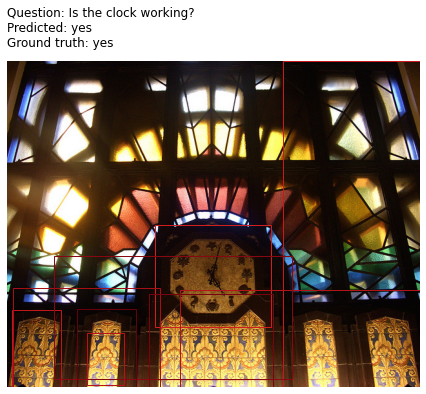

In [171]:
def visualize_bbox(row, ax=None, k=5):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 6))
    image_id = row['image_id']
    question = row['question']
    pred = row['answer']
    gt = row['answers'][0]['answer']

    with np.load(f'data/vqa/feats/val2014/COCO_val2014_000000{image_id:06}.jpg.npz') as npz:
        image_info = dict(zip(npz.files, npz.values()))

    image = plt.imread(f'data/vqa/raw/val2014/COCO_val2014_000000{image_id:06}.jpg')

    ax.imshow(image)

    feat_sum = image_info['x'].sum(axis=0)
    idx = feat_sum.argsort()
    feat_sum_k = feat_sum[idx][-k:]
    norm = mpl.colors.Normalize()
    cmap = plt.cm.Reds
    norm(feat_sum)
    colors = cmap(norm(feat_sum_k))

#     for bbox in image_info['bbox']:
#         x0, y0, x1, y1 = bbox
#         bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor='white')
#         ax.add_patch(bbox_patch)

    bboxes = image_info['bbox'][idx][-k:]
    for bbox, color in zip(bboxes, colors):
        x0, y0, x1, y1 = bbox
        bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor=color)
        ax.add_patch(bbox_patch)

    text = f'Question: {question}\nPredicted: {pred}\nGround truth: {gt}'
    ax.text(0, 1.1, text, transform=ax.transAxes, va='center', ha='left')
    ax.set_axis_off()

# visualize_bbox(df.loc[98570])
visualize_bbox(df.loc[75548], k=9)
# visualize_bbox(df.loc[77765], k=1)

In [162]:
df[df.question.str.startswith('How many lines are on the item')]

,image_id,question_id,question_type,question,answer_type,multiple_choice_answer,answers,answer
77765,305412,305412002,how many,How many lines are on the item?,number,18,"[{'answer': '18', 'answer_confidence': 'maybe'...",20
192159,378548,378548012,how many,How many lines are on the item?,number,0,"[{'answer': '0', 'answer_confidence': 'yes', '...",0


# Attention

In [157]:
# visualize_bbox(df.loc[98570])

# Number

In [158]:
number_wrong = wrong.query('answer_type=="number"')
number_wrong.head()

,image_id,question_id,question_type,question,answer_type,multiple_choice_answer,answers,answer
21,262162,262162003,how many,How many pictures are there?,number,7,"[{'answer': '7', 'answer_confidence': 'yes', '...",8
40,262162,262162022,how many,How many frames are on the wall?,number,7,"[{'answer': '7', 'answer_confidence': 'yes', '...",6
47,262162,262162029,how many,How many pictures on the wall?,number,7,"[{'answer': '7', 'answer_confidence': 'yes', '...",8
68,262189,262189000,how many,How many signs?,number,4,"[{'answer': '4', 'answer_confidence': 'yes', '...",3
78,262197,262197000,how many,How many skyscrapers are there?,number,2,"[{'answer': '2', 'answer_confidence': 'yes', '...",1


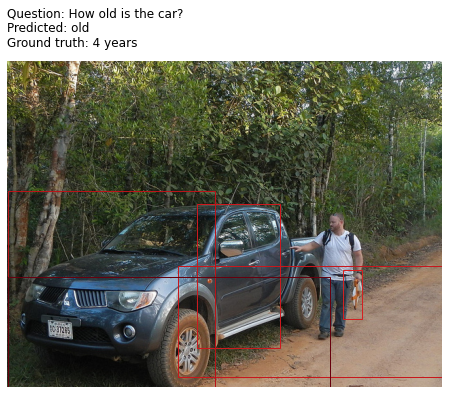

In [159]:
row = number_wrong.iloc[np.random.randint(len(number_wrong))]
visualize_bbox(row)